# 5.1 3D Reconstruction with Pairwise Alignment on Drosophila Data (bin50)

In this tutorial, you will learn how to reconstruct a 3D spatial transcriptomics by aligning the consecutive spatial transcriptomics slices serially (basic).

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Running this notebook on: ", device)

import spateo as st
print("Last run with spateo version:", st.__version__)

# Other imports
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import dynamo as dyn
import numpy as np
import anndata as ad

# Uncomment the following if running on the server
import pyvista as pv
pv.start_xvfb()

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Running this notebook on:  cuda
Last run with spateo version: 1.1.0.dev48+bbacf0a.dirty


## Loading the Data

In this tutorial, we will use the Drosophila dataset at stages E14-E16, obtained using the Stereo-Seq technique. You can download the raw data from [Flysta3D](https://db.cngb.org/stomics/flysta3d/) or from the links below. After downloading, be sure to place the data in the appropriate directory. 

- [Drosophila E14-E16](https://drive.google.com/file/d/1BP59v5DrLGXvpVMyUNJPIfWDvjMd3NWs/view?usp=drive_link)

In [5]:
adata = st.read('./data/E14-16h_a_count_normal_stereoseq.h5ad')

adata

AnnData object with n_obs × n_vars = 15295 × 13668
    obs: 'slice_ID', 'raw_x', 'raw_y', 'new_x', 'new_y', 'new_z', 'annotation'
    obsm: 'X_umap', 'spatial'
    layers: 'raw_counts'

## Preprocessing

In the first step, we perform preprocessing. Here, we use Dynamo's preprocessing framework, which is simple and fast. 

In [6]:
preprocessor = dyn.preprocessing.Preprocessor()
preprocessor.preprocess_adata(adata, recipe="monocle")

|-----> Running monocle preprocessing pipeline...
|-----------> filtered out 145 outlier cells
|-----? No layers exist in adata, skipp filtering by shared counts
|-----------> filtered out 6533 outlier genes
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> [Preprocessor-monocle] completed [21.8389s]


In [7]:
dyn.tl.reduceDimension(adata, basis="pca")

|-----> retrieve data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method pynn selected
|-----> [UMAP] completed [29.9284s]


|-----------> plotting with basis key=X_umap
|-----------> skip filtering annotation by stack threshold when stacking color because it is not a numeric type


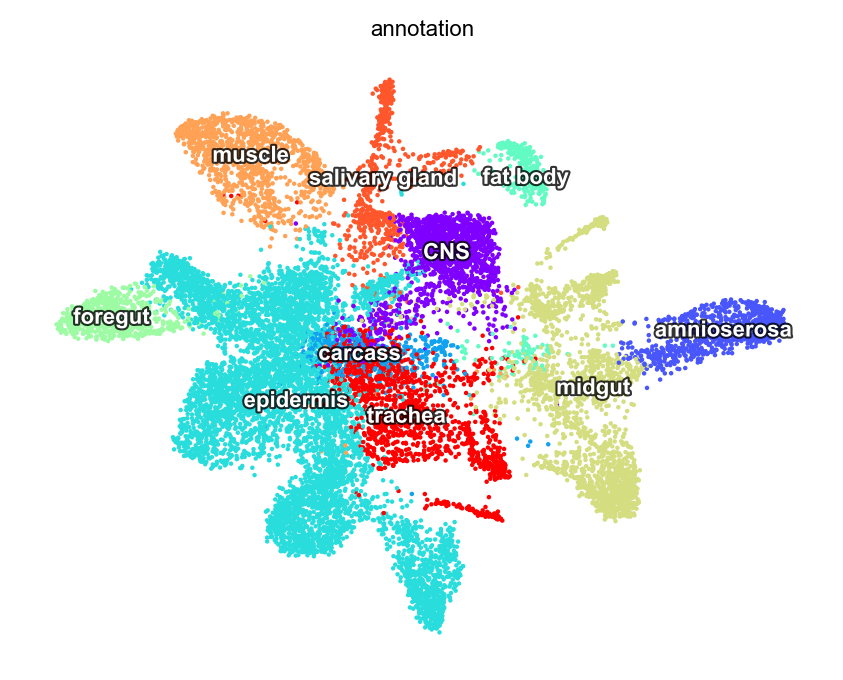

In [8]:
# Create a list of colors for each label using rainbow colors
import matplotlib.colors as mcolors
labels = adata.obs['annotation'].cat.categories.tolist()
colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))
palette = dict(zip(labels, colors))

dyn.pl.umap(adata, color='annotation', pointsize=0.02, alpha=1, color_key=palette)

In fact, they have already reconstructed the 3D Drosophila, and the reconstructed spatial coordinates are stored in ``new_x``, ``new_y``, and ``new_z``. To simulate the unaligned case, we generate a random rotation for each slice.

In [10]:
adata.obsm['spatial_3D'] = adata.obs[['new_x', 'new_y', 'new_z']].values.copy()
z_height = np.unique(adata.obsm['spatial_3D'][:,2])
slices = [adata[adata.obsm['spatial_3D'][:,2] == z] for z in z_height]
slices[0].obsm['spatial_2D'] = slices[0].obsm['spatial_3D'][:,:2]
for i in range(1, len(slices)):
    slices[i].obsm['spatial_2D'] = slices[i].obsm['spatial_3D'][:,:2].copy()
    # generate random rotation matrix
    st.align.rigid_transformation(slices[i], spatial_key='spatial_2D', key_added='spatial_2D')

The 2D visualization plot show the initial spatial coordinate.

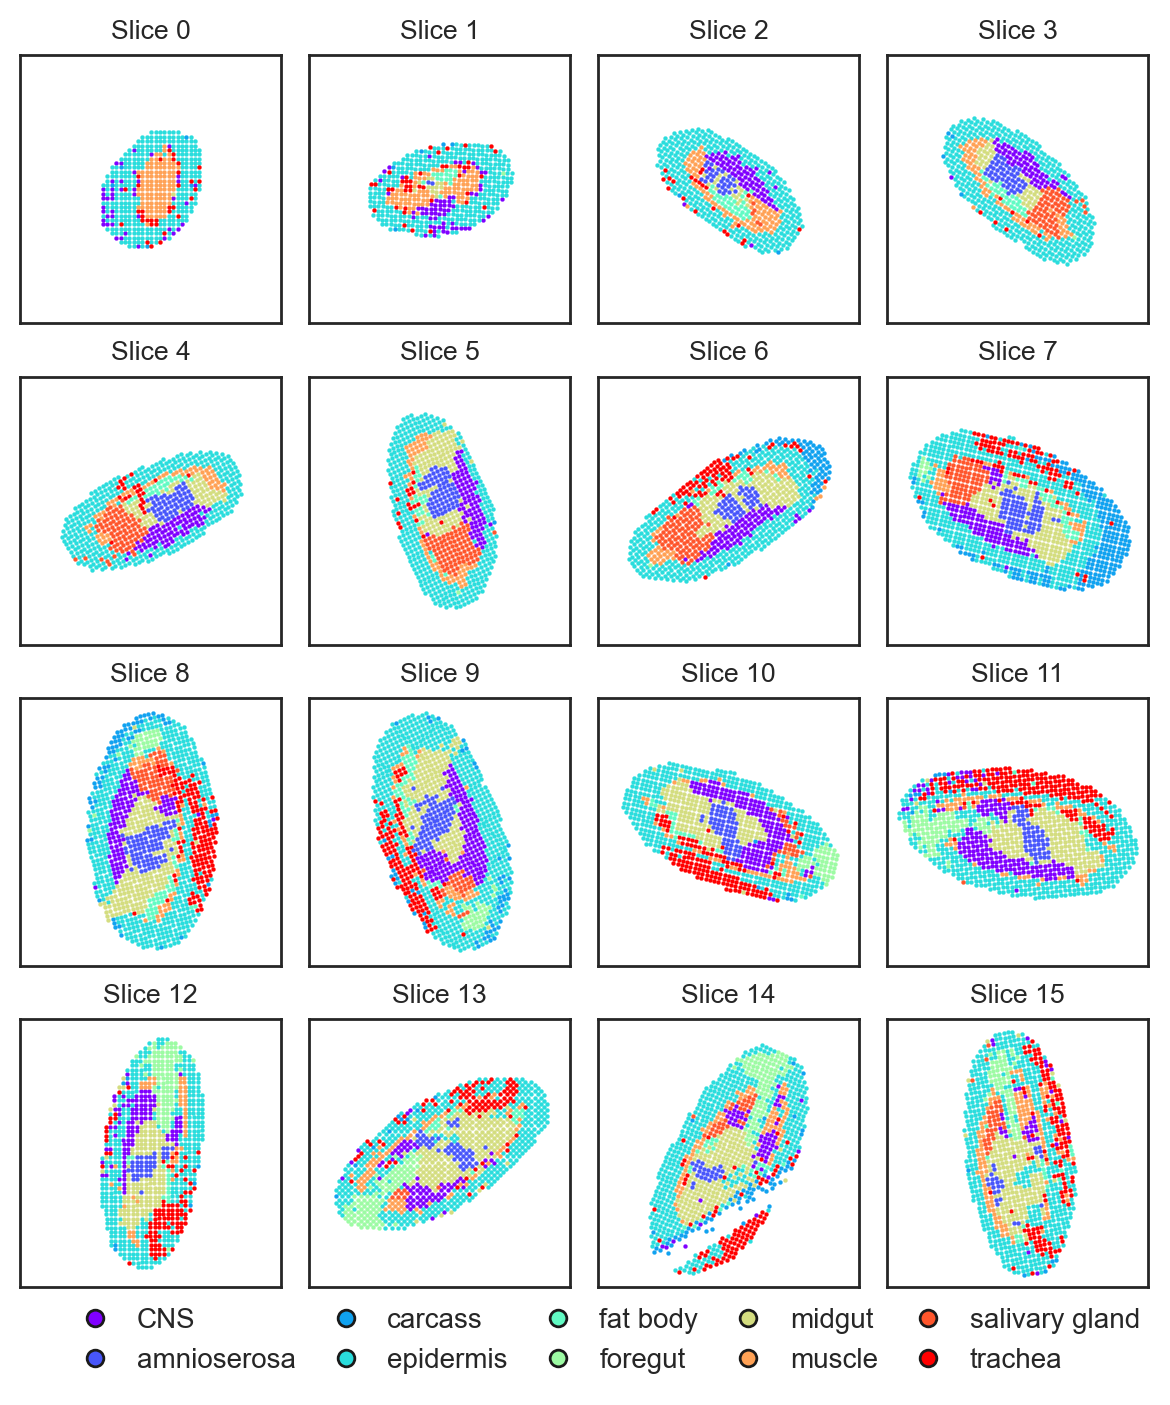

In [11]:
spatial_key = 'spatial_2D'
cluster_key = 'annotation'

st.pl.slices_2d(
    slices = slices,
    label_key = cluster_key,
    spatial_key = spatial_key,
    height=2,
    center_coordinate=True,
    show_legend=True,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.5, 0) ,'ncol': 5, 'borderaxespad': -6, 'frameon': False},
    palette=palette,
)

## Pairwise rigid alignment

Next, we calculate the spatial transformation between each pair of adjacent slices through pairwise rigid alignment and save these transformations in ``transformation`` (with a length of ``len(slices)-1``) using ``st.align.morpho_align_transformation``. 

In [12]:
key_added = 'align_spatial'
transformation = st.align.morpho_align_transformation(
    models=slices,
    spatial_key=spatial_key,
    key_added=key_added,
    device=device,
    verbose=False,
    rep_layer='X_pca',
    rep_field='obsm',
    dissimilarity='cos',
)

|-----> [Models alignment based on morpho.] in progress: 100.0000%
|-----> [Models alignment based on morpho.] finished [29.4830s]


The output transformations include both a rotation matrix and a translation matrix

In [16]:
transformation[0]

{'Rotation': array([[-0.53751908,  0.84325158],
        [-0.84325158, -0.53751908]]),
 'Translation': array([0.71284574, 0.31073377])}

We then align these spatial transformations to unify the coordinate system of all slices, aligning them with the first slice (which remains unchanged).

In [13]:
aligned_slices = st.align.morpho_align_apply_transformation(
    models=slices,
    spatial_key=spatial_key,
    key_added=key_added,
    transformation=transformation,
)

|-----> [Models alignment based on morpho, applying transformation.] in progress: 100.0000%
|-----> [Models alignment based on morpho, applying transformation.] finished [0.0098s]


## Plot the aligned slices

After the alignment, we can visualize the aligned slices to check whether the pairwise alignment results are correct.

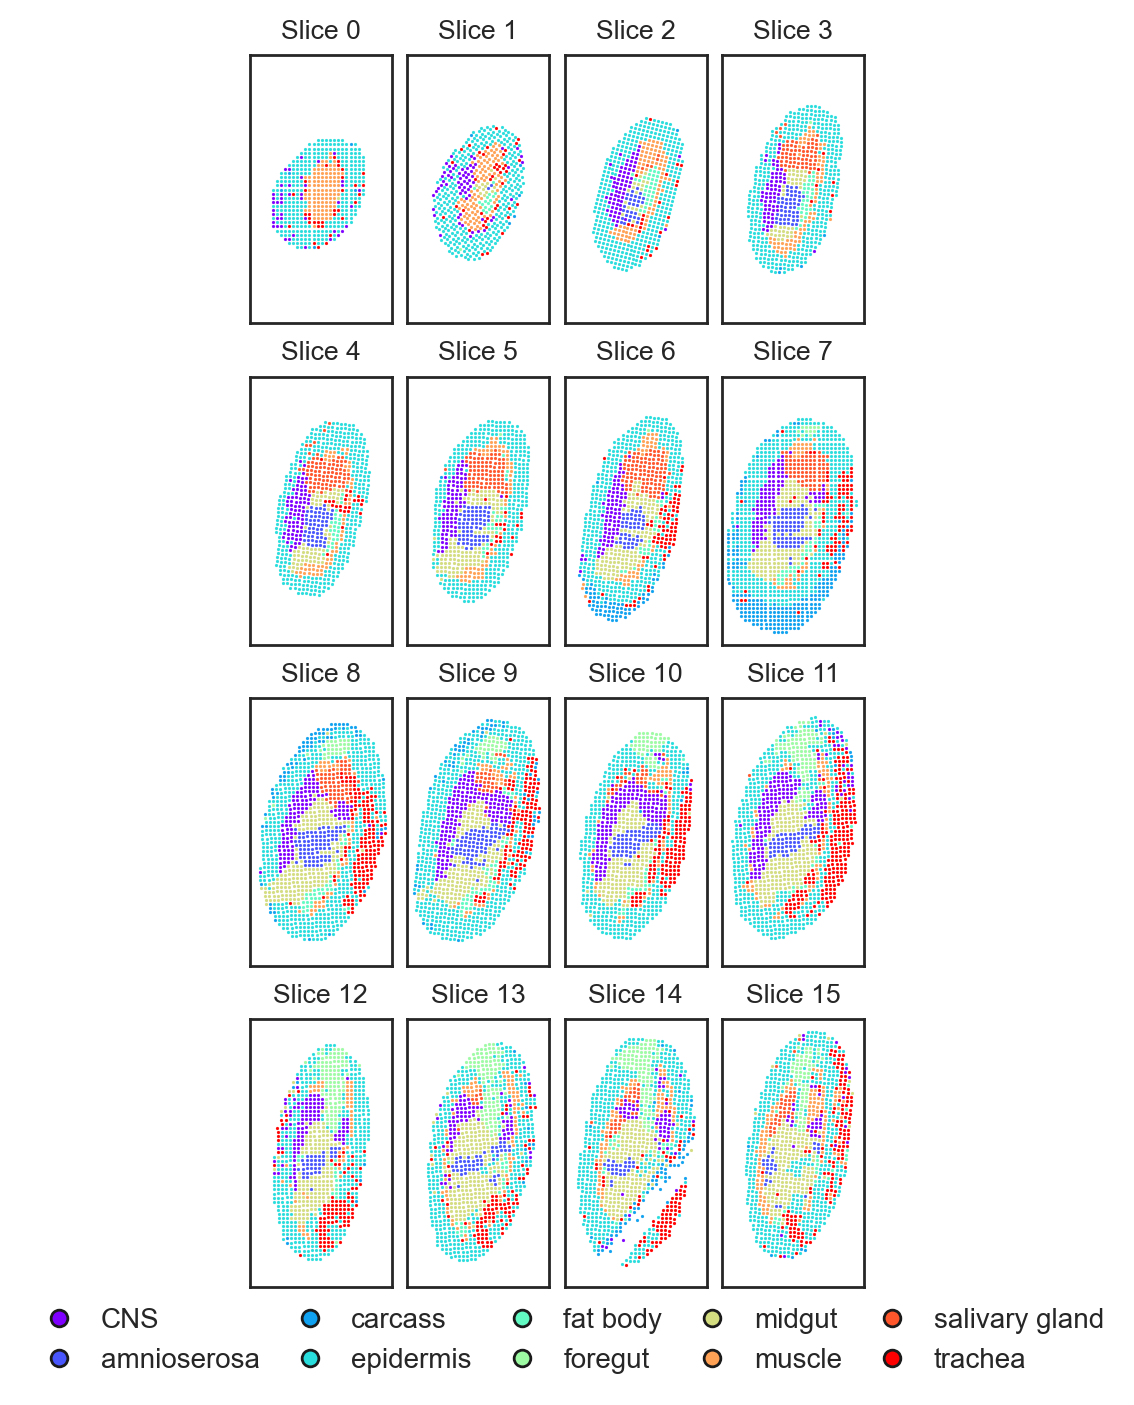

In [17]:
st.pl.slices_2d(
    slices = aligned_slices,
    label_key = cluster_key,
    spatial_key = key_added,
    height=2,
    center_coordinate=False,
    show_legend=True,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.5, 0) ,'ncol': 5, 'borderaxespad': -6, 'frameon': False},
    palette=palette,
)

Since the Drosophila data is already aligned, we can compare the alignment results. Here, we select slices #5, #6, and #7 and overlay them. We can see that Spateo's aligned results are better.

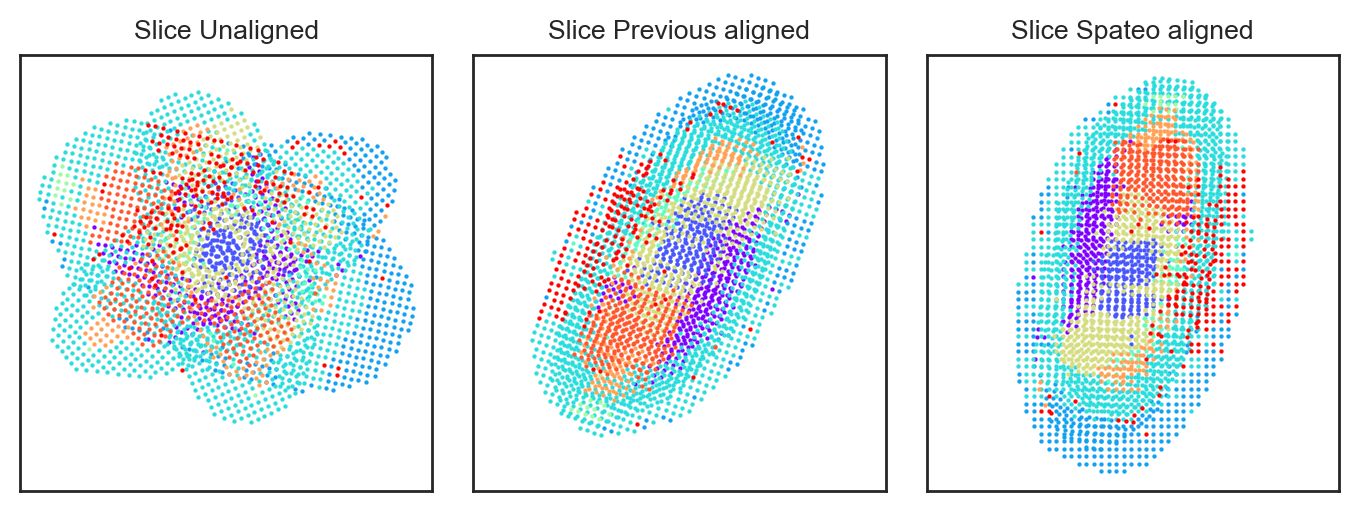

In [21]:
unaligned_slices_overlap_plot = ad.concat(aligned_slices[5:8])
unaligned_slices_overlap_plot.obsm['plot_spatial'] = unaligned_slices_overlap_plot.obsm['spatial_2D']
unaligned_slices_overlap_plot.obs['title'] = 'Unaligned'

aligned_slices_overlap_plot = unaligned_slices_overlap_plot.copy()
aligned_slices_overlap_plot.obsm['plot_spatial'] = aligned_slices_overlap_plot.obsm['align_spatial']
aligned_slices_overlap_plot.obs['title'] = 'Spateo aligned'

previous_aligned_slices_overlap_plot = unaligned_slices_overlap_plot.copy()
previous_aligned_slices_overlap_plot.obsm['plot_spatial'] = previous_aligned_slices_overlap_plot.obsm['spatial_3D'][:,:2]
previous_aligned_slices_overlap_plot.obs['title'] = 'Previous aligned'

st.pl.slices_2d(
    slices = [unaligned_slices_overlap_plot, previous_aligned_slices_overlap_plot, aligned_slices_overlap_plot],
    label_key = cluster_key,
    spatial_key = 'plot_spatial',
    height=3,
    center_coordinate=False,
    show_legend=False,
    palette=palette,
    point_size=2,
    slices_key='title',
)

## 3D Visualization

In the end, we concatenate the aligned slices and restore the z-axis data to obtain the 3D reconstruction result using pairwise rigid alignment. The 3D visualization is then performed using Spateo's built-in plotting functions.

In [22]:
aligned_adata = ad.concat(aligned_slices)
aligned_adata.obsm['aligned_spatial_3D'] = np.concatenate([aligned_adata.obsm['align_spatial'], np.array(aligned_adata.obsm['spatial_3D'][:,2])[:,None]], axis=1)

In [ ]:
# save the results
aligned_adata.write_h5ad('./results/Drosophila_E14-16h_rigid_alignment.h5ad')

In [23]:
aligned_pc, _ = st.tdr.construct_pc(adata=aligned_adata,spatial_key="aligned_spatial_3D",groupby=cluster_key,key_added="tissue",colormap=palette,)

aligned_pc

PolyData (0x7f676049cf40)
  N Cells:    15150
  N Points:   15150
  N Strips:   0
  X Bounds:   -1.517e+01, 1.631e+01
  Y Bounds:   -2.867e+01, 3.068e+01
  Z Bounds:   1.000e+00, 1.600e+01
  N Arrays:   3

<div class="alert alert-warning">
<strong>Warning:</strong>

The following code block involves [PyVista](https://docs.pyvista.org/) visualization. Before running the PyVista-based visualization function `st.pl.three_d_plot`, please ensure that PyVista is installed correctly, especially for server configurations. Incorrect installation may cause Jupyter Notebook to crash. There are certain specifications to consider when running PyVista on a remote server. We recommend reviewing their [tutorials](https://docs.pyvista.org/user-guide/jupyter/trame.html#remote-jupyter-host), particularly for remote Jupyter environments.
    
</div>

<div class="alert alert-info">
<strong>Tips:</strong>

You can enable interactive visualization by changing the PyVista backend via the jupyter parameter in ``st.pl.three_d_plot``. Setting ``jupyter='static'`` will output a static image. I recommend using ``'html'`` for lightweight interactive visualization. Another very convenient feature is that you can save the interactive 3D visualization as an HTML file by specifying ``plotter_filename`` in ``st.pl.three_d_plot``, making it much easier to share results
    
</div>

``st.pl.three_d_plot`` provides an easy way to visualize 3D plots.

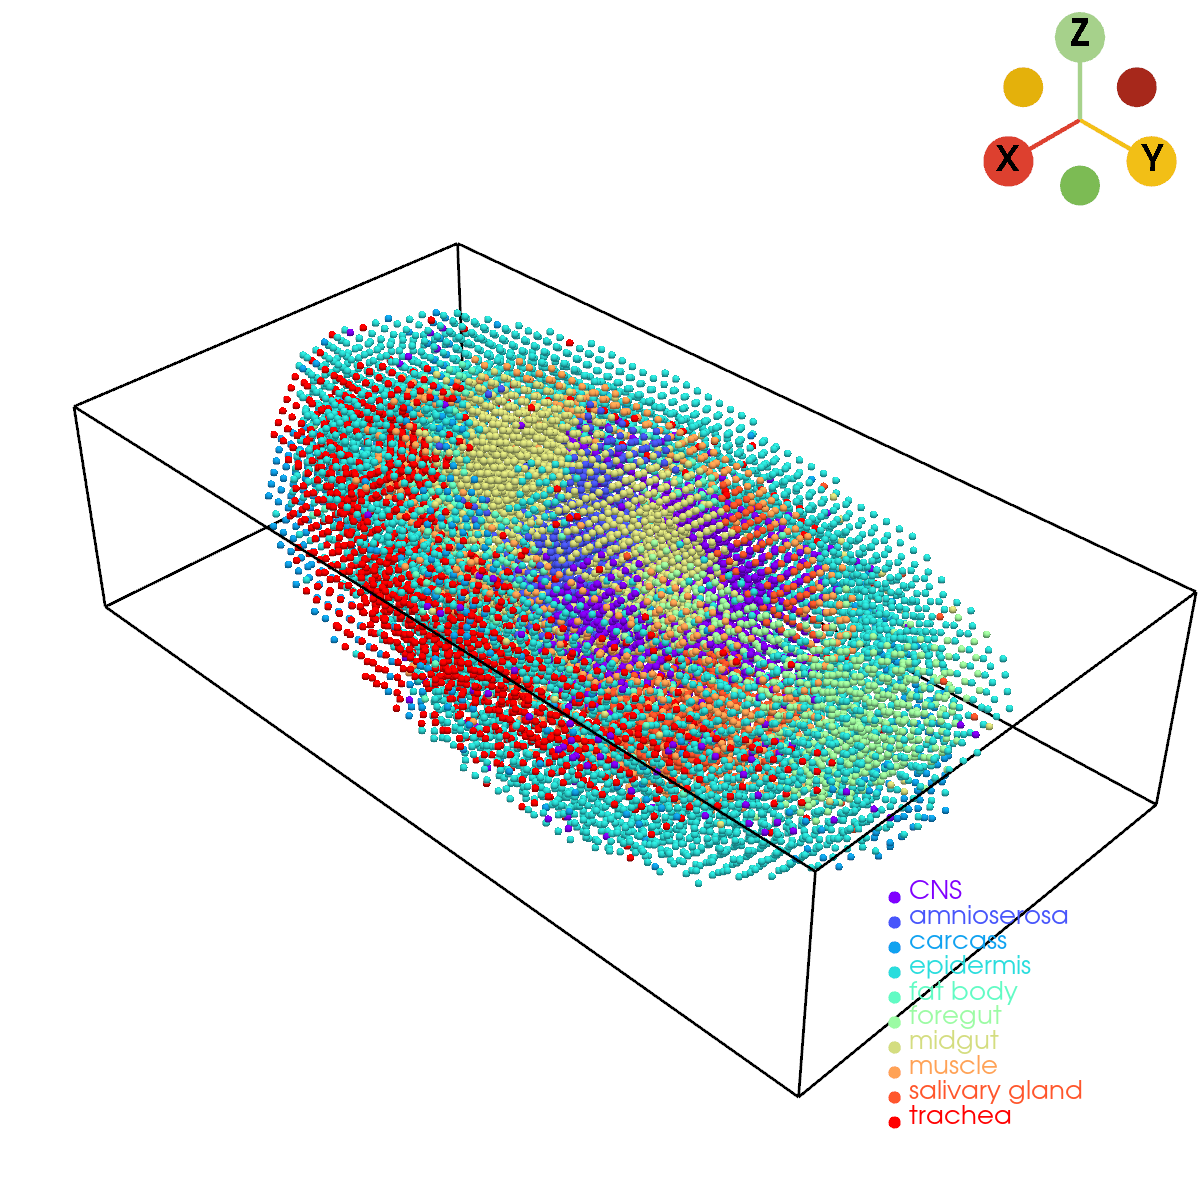

In [24]:
# show the aligned drosophila in 3D
st.pl.three_d_plot(model=aligned_pc,key="tissue",model_style='points',model_size=8, show_axes=True,
    jupyter="static",window_size=(1200, 1200),show_outline=True,outline_kwargs={'show_labels': False, 'outline_width': 3},
    # plotter_filename='./results/Drosophila_8_9_rigid_alignment_reconstruction.html',  # uncomment this for saving the interactive 3D visualization
)

We can also compare with the spatial provided by the data itself.

In [25]:
previous_pc, _ = st.tdr.construct_pc(adata=aligned_adata,spatial_key="spatial_3D",groupby=cluster_key,key_added="tissue",colormap=palette,)

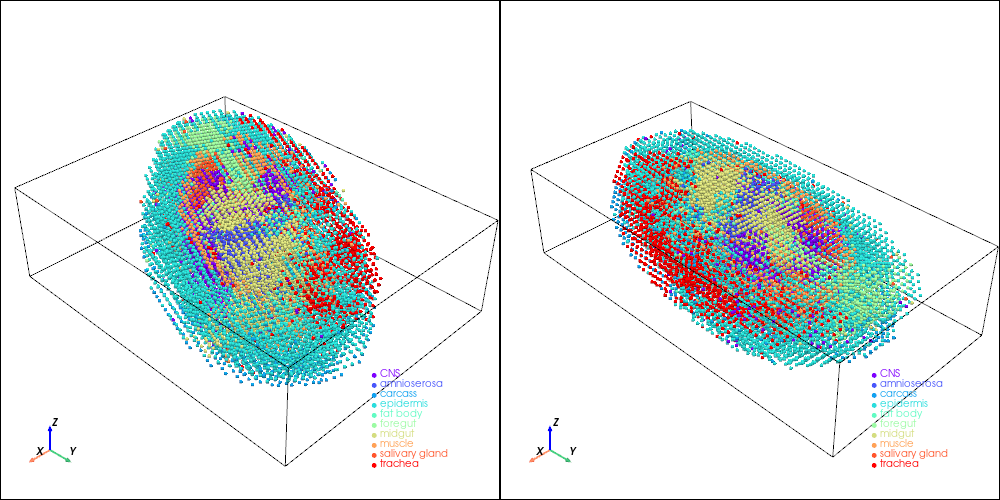

In [29]:
st.pl.three_d_multi_plot(model=st.tdr.collect_models([previous_pc, aligned_pc]),key="tissue",model_style='points',model_size=4, 
    jupyter="static",window_size=(500, 500),show_outline=True,outline_kwargs={'show_labels': False, 'outline_width': 1},
)

Let's highlight some of the cluster to show the reconstructed 3D patterns

In [31]:
highlight_tissues = ['CNS', 'midgut', 'salivary gland', ]
pc_origin_highlight = previous_pc.copy()
pc_highlight = aligned_pc.copy()
pc_highlight['tissue_rgba'][:,3] = 0.02
pc_highlight['tissue_rgba'][aligned_adata.obs[cluster_key].isin(highlight_tissues),3] = 1
pc_origin_highlight['tissue_rgba'][:,3] = 0.02
pc_origin_highlight['tissue_rgba'][aligned_adata.obs[cluster_key].isin(highlight_tissues),3] = 1

Because the coordinates are the same. For better comparison, we rotate the point cloud (this will not affect AnnData it self)

In [32]:
pc_origin_highlight = pc_origin_highlight.rotate_z(205)

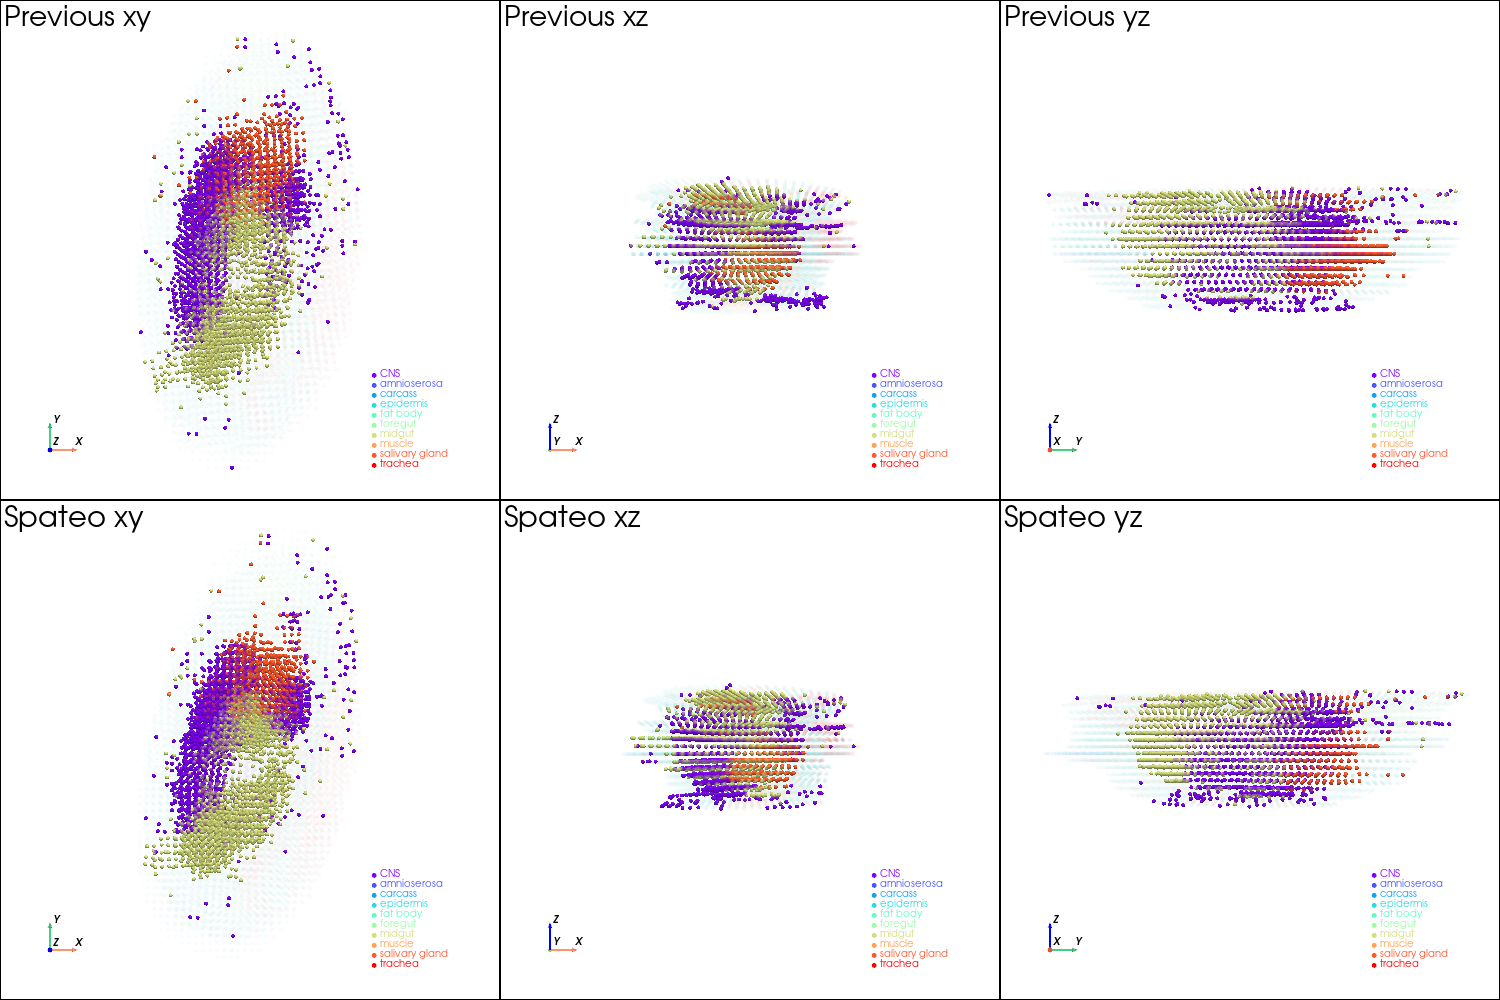

In [34]:
# show the aligned drosophila in 3D
st.pl.three_d_multi_plot(model=st.tdr.collect_models([pc_origin_highlight, pc_origin_highlight, pc_origin_highlight, pc_highlight, pc_highlight, pc_highlight]),
                         key="tissue",model_style='points',model_size=4, cpo=['xy', 'xz', 'yz', 'xy', 'xz', 'yz', ],   jupyter="static",window_size=(500, 500),
                         text=['Previous xy', 'Previous xz', 'Previous yz', 'Spateo xy', 'Spateo xz', 'Spateo yz']
)